In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
from lib.zebra_grid import get_zebra_grid_tasks
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb


run_name = "043"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "zebra-grid"},
)

tasks = list(get_zebra_grid_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 872)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 1000  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.0)
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.qwen_32b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

$ vllm serve Qwen/Qwen2.5-32B-Instruct --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --port=8000 --api-key=default
INFO 02-24 21:44:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-24 21:44:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-24 21:44:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='Qwen/Qwen2.5-32B-Instruct', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   6% Completed | 1/17 [00:00<00:06,  2.55it/s]
Loading safetensors checkpoint shards:  12% Completed | 2/17 [00:00<00:05,  2.88it/s]
Loading safetensors checkpoint shards:  18% Completed | 3/17 [00:01<00:04,  3.01it/s]
Loading safetensors checkpoint shards:  24% Completed | 4/17 [00:01<00:04,  3.06it/s]
Loading safetensors checkpoint shards:  29% Completed | 5/17 [00:01<00:03,  3.53it/s]
Loading safetensors checkpoint shards:  35% Completed | 6/17 [00:01<00:03,  3.41it/s]
Loading safetensors checkpoint shards:  41% Completed | 7/17 [00:02<00:03,  3.29it/s]
Loading safetensors checkpoint shards:  47% Completed | 8/17 [00:02<00:02,  3.22it/s]
Loading safetensors checkpoint shards:  53% Completed | 9/17 [00:02<00:02,  3.16it/s]
Loading safetensors checkpoint shards:  59% Completed | 10/17 [00:03<00:02,  3.12it/s]
Loading safetensors checkpoint shards:  65% Completed | 11/17

(VllmWorkerProcess pid=13973) INFO 02-24 21:46:25 model_runner.py:1115] Loading model weights took 15.3917 GB


Loading safetensors checkpoint shards: 100% Completed | 17/17 [00:05<00:00,  3.27it/s]
Loading safetensors checkpoint shards: 100% Completed | 17/17 [00:05<00:00,  3.15it/s]



(VllmWorkerProcess pid=13972) INFO 02-24 21:46:26 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=13974) INFO 02-24 21:46:26 model_runner.py:1115] Loading model weights took 15.3917 GB
INFO 02-24 21:46:26 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=13972) INFO 02-24 21:46:31 worker.py:267] Memory profiling takes 5.33 seconds
(VllmWorkerProcess pid=13972) INFO 02-24 21:46:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=13972) INFO 02-24 21:46:31 worker.py:267] model weights take 15.39GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.19GiB.
(VllmWorkerProcess pid=13974) INFO 02-24 21:46:31 worker.py:267] Memory profiling takes 5.32 seconds
(VllmWorkerProcess pid=13974) INFO 02-24 21:46:31 worker.py:267] the current vLLM instance can use

INFO:     Started server process [13609]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-24 21:47:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-24 21:47:39 metrics.py:455] Avg prompt throughput: 5.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-24 21:47:39 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:60164 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:39<00:00, 10.89it/s, completion_tokens=802, prompt_tokens=392, reward=0.539, token_logprobs=2567471]


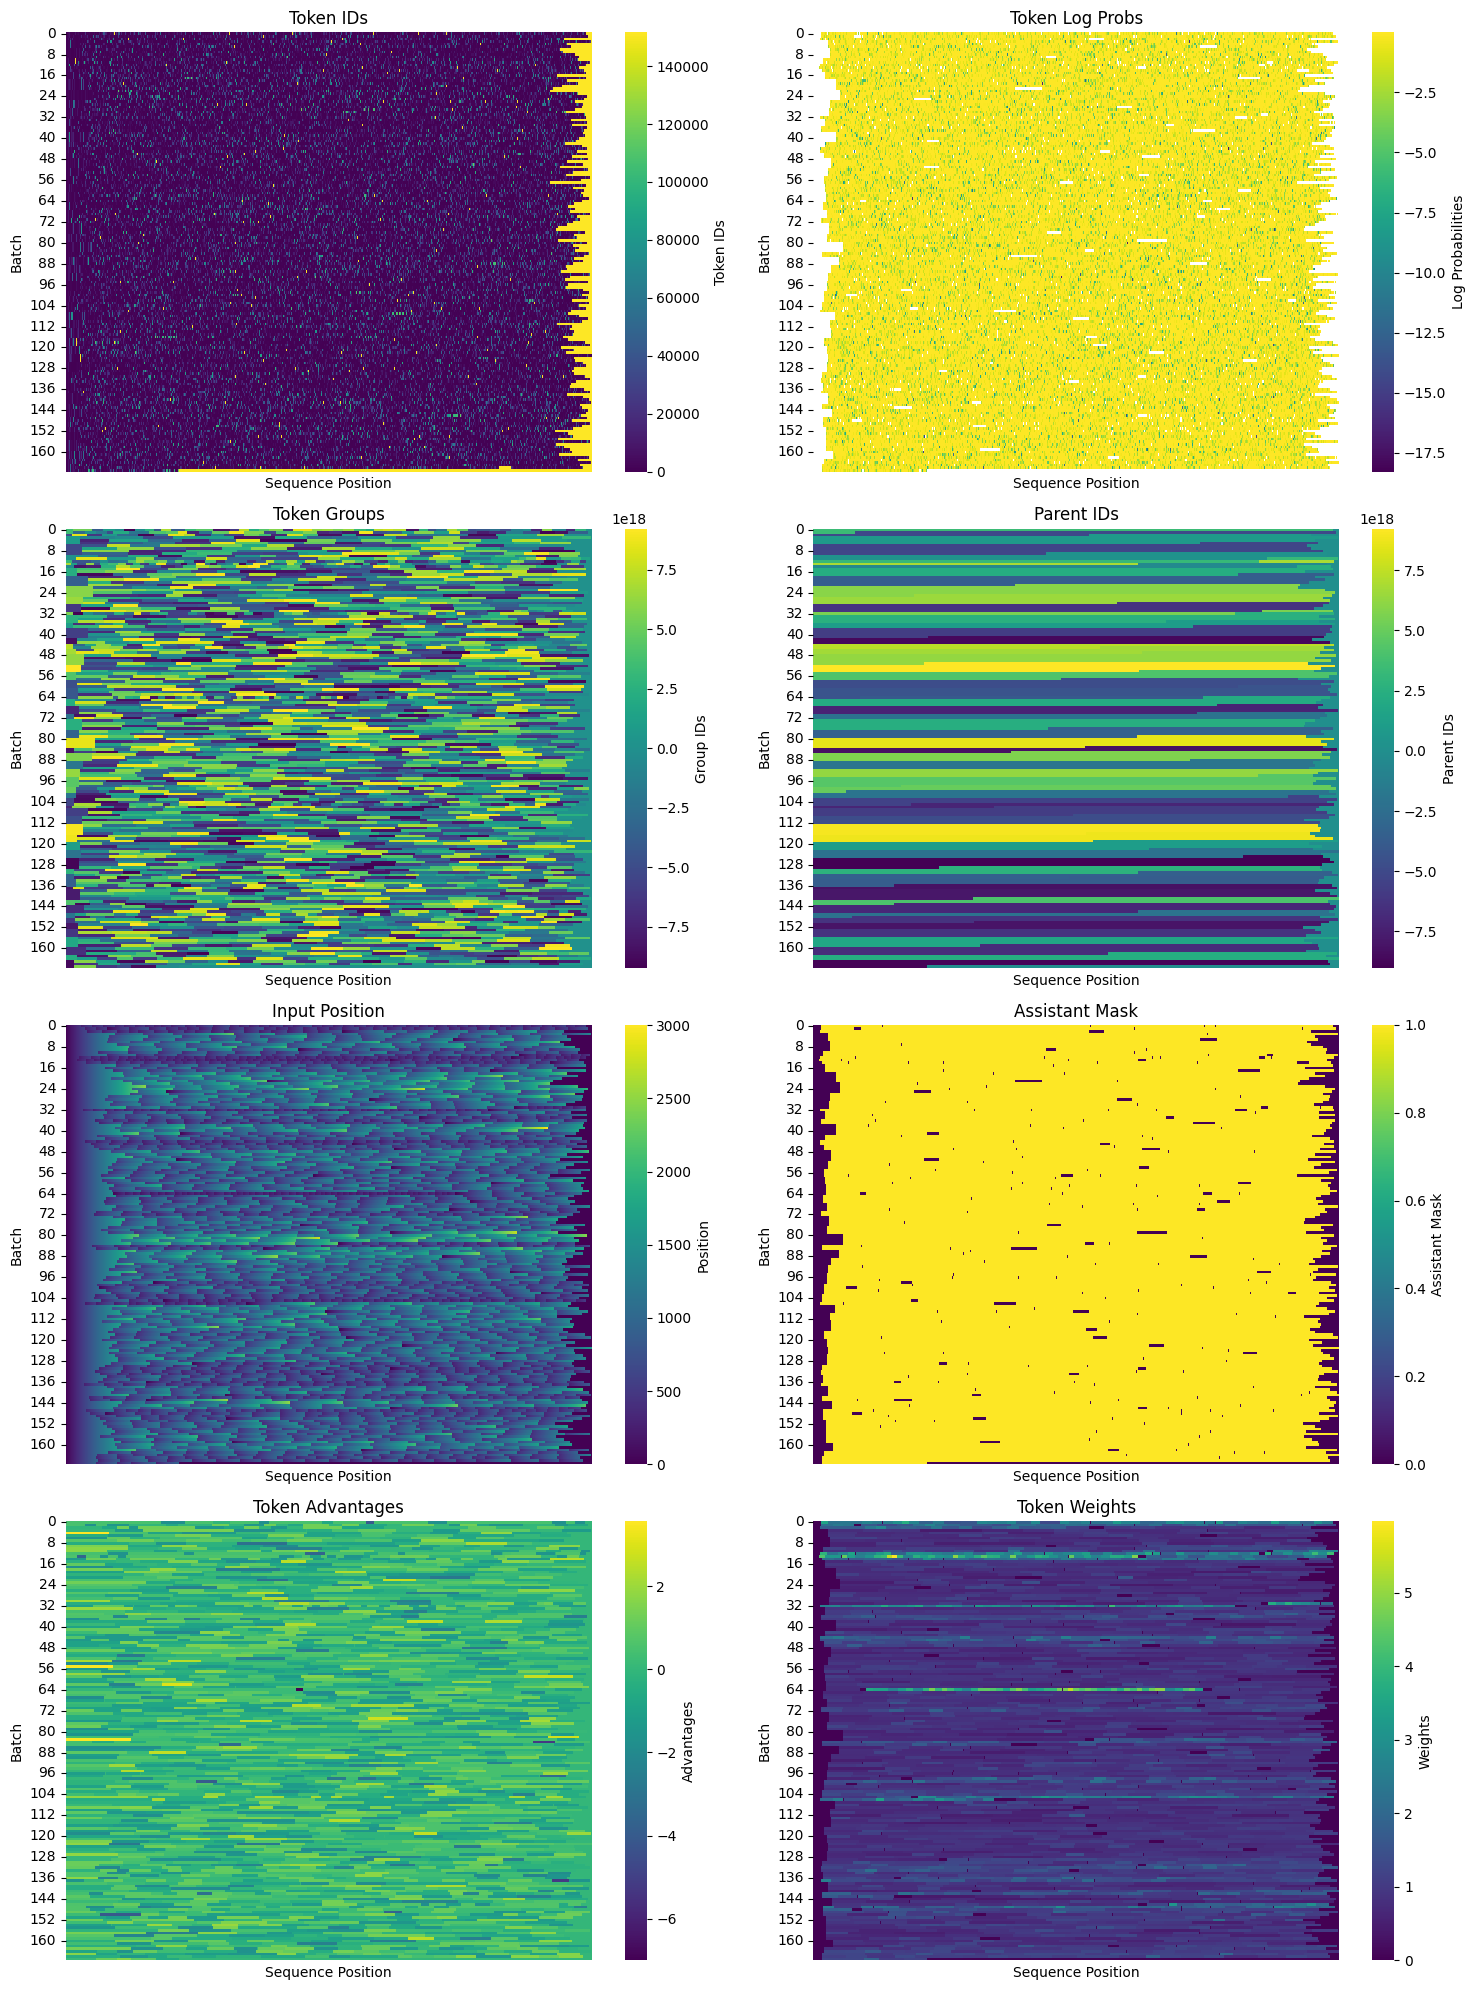

Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-32B-Instruct/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-32B-Instruct/blobs/6634c8cc3133b3848ec74b9f275acaaa1ea618ab
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-32B-Instruct/blobs/761da35f2465ff5ecaae7902edf5549ea97bd7fa
$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/043/config.yaml
Running with torchrun...


W0224 21:53:59.570000 18997 torch/distributed/run.py:793] 
W0224 21:53:59.570000 18997 torch/distributed/run.py:793] *****************************************
W0224 21:53:59.570000 18997 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0224 21:53:59.570000 18997 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-32B-Instruct/snapshots/5ede1c97bbab6ce5cda5812749b4c0bdf79b18dd
  checkpoint_files:
  - model-00015-of-00017.safetensors
  - m

Writing logs to models/043/logs/log_1740434045.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 35.87 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.81 GiB
	GPU peak memory reserved: 3.88 GiB
	GPU peak memory active: 3.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|21|Loss: -0.0004: 100%|██████████| 21/21 [17:48<00:00, 49.15s/it, entropy=0.552, kl_div=nan, loss=-0.00043, policy=-0.00043]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /dev/shm/models/043 to gs:/atreides/openpipe/models/043
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/043/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/043/0001 --port=8000 --api-key=default
INFO 02-24 22:14:39 __init__.py:190] Automatically detected platform cuda.
INFO 02-24 22:14:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-24 22:14:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/043/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, cha

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   6% Completed | 1/17 [00:00<00:04,  3.59it/s]
Loading safetensors checkpoint shards:  12% Completed | 2/17 [00:00<00:04,  3.04it/s]
Loading safetensors checkpoint shards:  18% Completed | 3/17 [00:01<00:04,  2.89it/s]
Loading safetensors checkpoint shards:  24% Completed | 4/17 [00:01<00:04,  2.83it/s]
Loading safetensors checkpoint shards:  29% Completed | 5/17 [00:01<00:04,  2.79it/s]
Loading safetensors checkpoint shards:  35% Completed | 6/17 [00:02<00:03,  2.76it/s]
Loading safetensors checkpoint shards:  41% Completed | 7/17 [00:02<00:03,  2.75it/s]
Loading safetensors checkpoint shards:  47% Completed | 8/17 [00:02<00:03,  2.73it/s]
Loading safetensors checkpoint shards:  53% Completed | 9/17 [00:03<00:02,  2.73it/s]
Loading safetensors checkpoint shards:  59% Completed | 10/17 [00:03<00:02,  2.72it/s]
Loading safetensors checkpoint shards:  65% Completed | 11/17

(VllmWorkerProcess pid=24258) INFO 02-24 22:15:04 model_runner.py:1115] Loading model weights took 15.3917 GB
INFO 02-24 22:15:05 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=24257) INFO 02-24 22:15:05 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=24256) INFO 02-24 22:15:05 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=24258) INFO 02-24 22:15:09 worker.py:267] Memory profiling takes 3.72 seconds
(VllmWorkerProcess pid=24258) INFO 02-24 22:15:09 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=24258) INFO 02-24 22:15:09 worker.py:267] model weights take 15.39GiB; non_torch_memory takes 3.66GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.65GiB.
(VllmWorkerProcess pid=24257) INFO 02-24 22:15:09 worker.py:267] Memory profiling takes 3

INFO:     Started server process [22352]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-24 22:16:15 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:43668 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [06:24<00:00,  6.60s/it, completion_tokens=858, prompt_tokens=420, reward=0.558, token_logprobs=2746645]


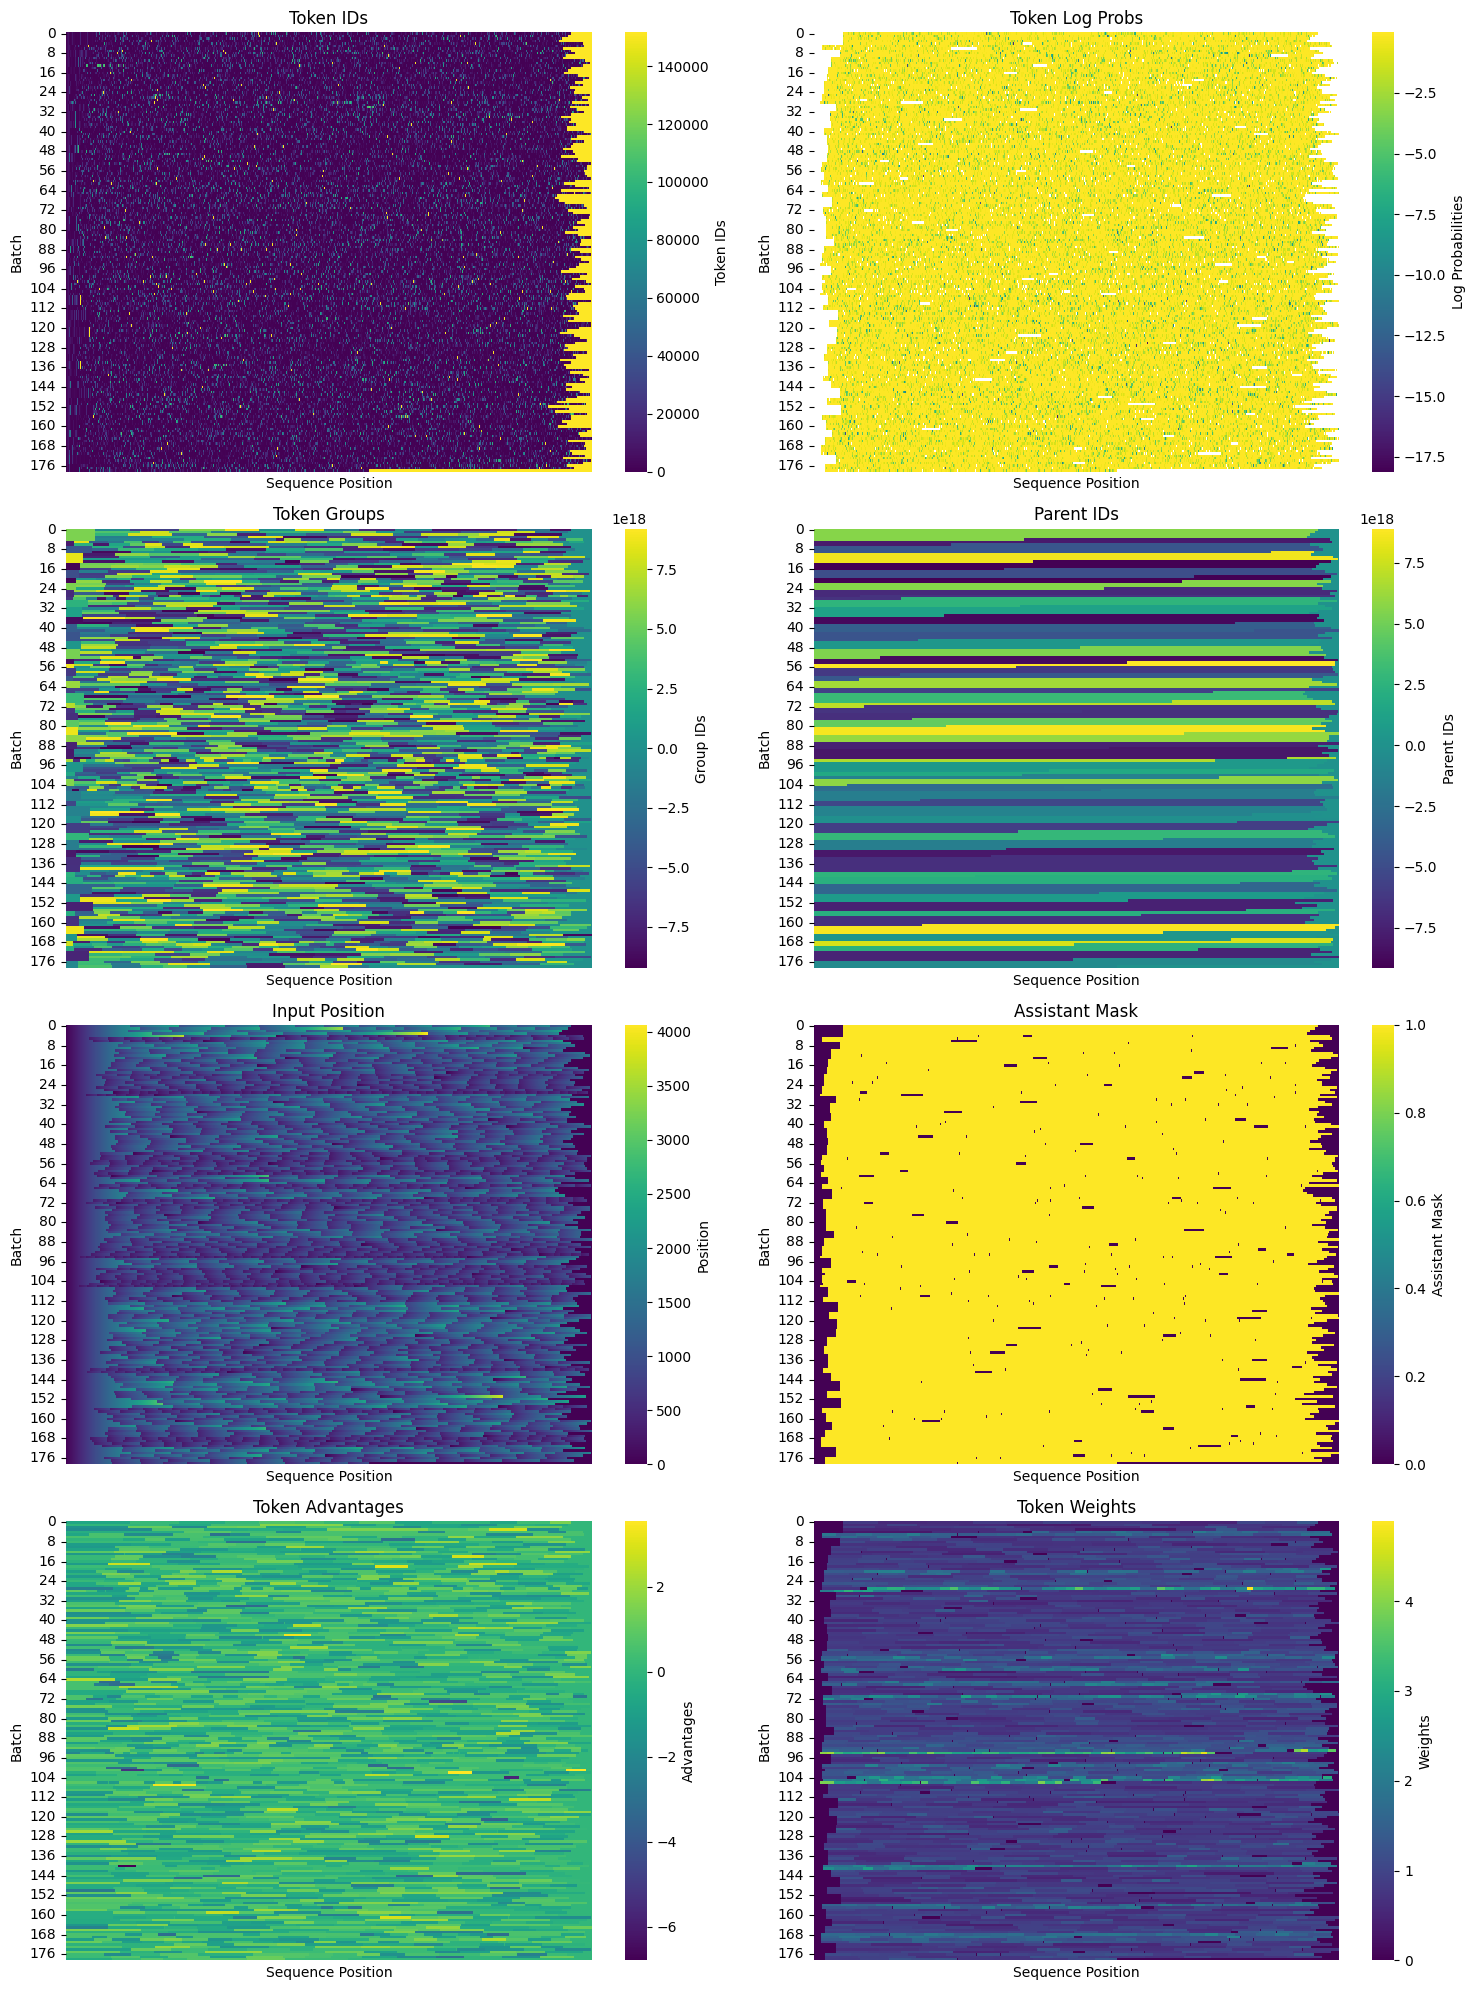

rsyncing /dev/shm/models/043 to gs:/atreides/openpipe/models/043
$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/043/config.yaml
Running with torchrun...


W0224 22:23:21.836000 25239 torch/distributed/run.py:793] 
W0224 22:23:21.836000 25239 torch/distributed/run.py:793] *****************************************
W0224 22:23:21.836000 25239 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0224 22:23:21.836000 25239 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/043/0001
  checkpoint_files:
  - ft-model-00001-of-00017.safetensors
  - ft-model-00002-of-00017.safetensors
  - ft-model-00003-of-00017.safetensors
  - ft-model-00004-of-00017

Writing logs to models/043/logs/log_1740435807.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 35.03 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.81 GiB
	GPU peak memory reserved: 3.88 GiB
	GPU peak memory active: 3.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|22|Loss: -0.0001: 100%|██████████| 22/22 [18:29<00:00, 49.11s/it, entropy=0.597, kl_div=nan, loss=-5.21e-5, policy=-5.21e-5]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

rsyncing /dev/shm/models/043 to gs:/atreides/openpipe/models/043
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/043/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/043/0002 --port=8000 --api-key=default
INFO 02-24 22:44:42 __init__.py:190] Automatically detected platform cuda.
INFO 02-24 22:44:43 api_server.py:840] vLLM API server version 0.7.2
INFO 02-24 22:44:43 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/043/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, cha

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   6% Completed | 1/17 [00:00<00:04,  3.98it/s]
Loading safetensors checkpoint shards:  12% Completed | 2/17 [00:00<00:04,  3.20it/s]
Loading safetensors checkpoint shards:  18% Completed | 3/17 [00:00<00:04,  2.93it/s]
Loading safetensors checkpoint shards:  24% Completed | 4/17 [00:01<00:04,  2.91it/s]
Loading safetensors checkpoint shards:  29% Completed | 5/17 [00:01<00:04,  2.80it/s]
Loading safetensors checkpoint shards:  35% Completed | 6/17 [00:02<00:03,  2.84it/s]
Loading safetensors checkpoint shards:  41% Completed | 7/17 [00:02<00:03,  2.85it/s]
Loading safetensors checkpoint shards:  47% Completed | 8/17 [00:02<00:03,  2.88it/s]
Loading safetensors checkpoint shards:  53% Completed | 9/17 [00:03<00:02,  2.89it/s]
Loading safetensors checkpoint shards:  59% Completed | 10/17 [00:03<00:02,  2.90it/s]
Loading safetensors checkpoint shards:  65% Completed | 11/17

(VllmWorkerProcess pid=30829) INFO 02-24 22:45:08 model_runner.py:1115] Loading model weights took 15.3917 GB
INFO 02-24 22:45:08 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=30831) INFO 02-24 22:45:08 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=30830) INFO 02-24 22:45:08 model_runner.py:1115] Loading model weights took 15.3917 GB
(VllmWorkerProcess pid=30829) INFO 02-24 22:45:12 worker.py:267] Memory profiling takes 3.74 seconds
(VllmWorkerProcess pid=30829) INFO 02-24 22:45:12 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=30829) INFO 02-24 22:45:12 worker.py:267] model weights take 15.39GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.19GiB.
(VllmWorkerProcess pid=30831) INFO 02-24 22:45:12 worker.py:267] Memory profiling takes 3

INFO:     Started server process [28948]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-24 22:46:14 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49206 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [06:26<00:00,  1.03it/s, completion_tokens=884, prompt_tokens=431, reward=0.556, token_logprobs=2827193]


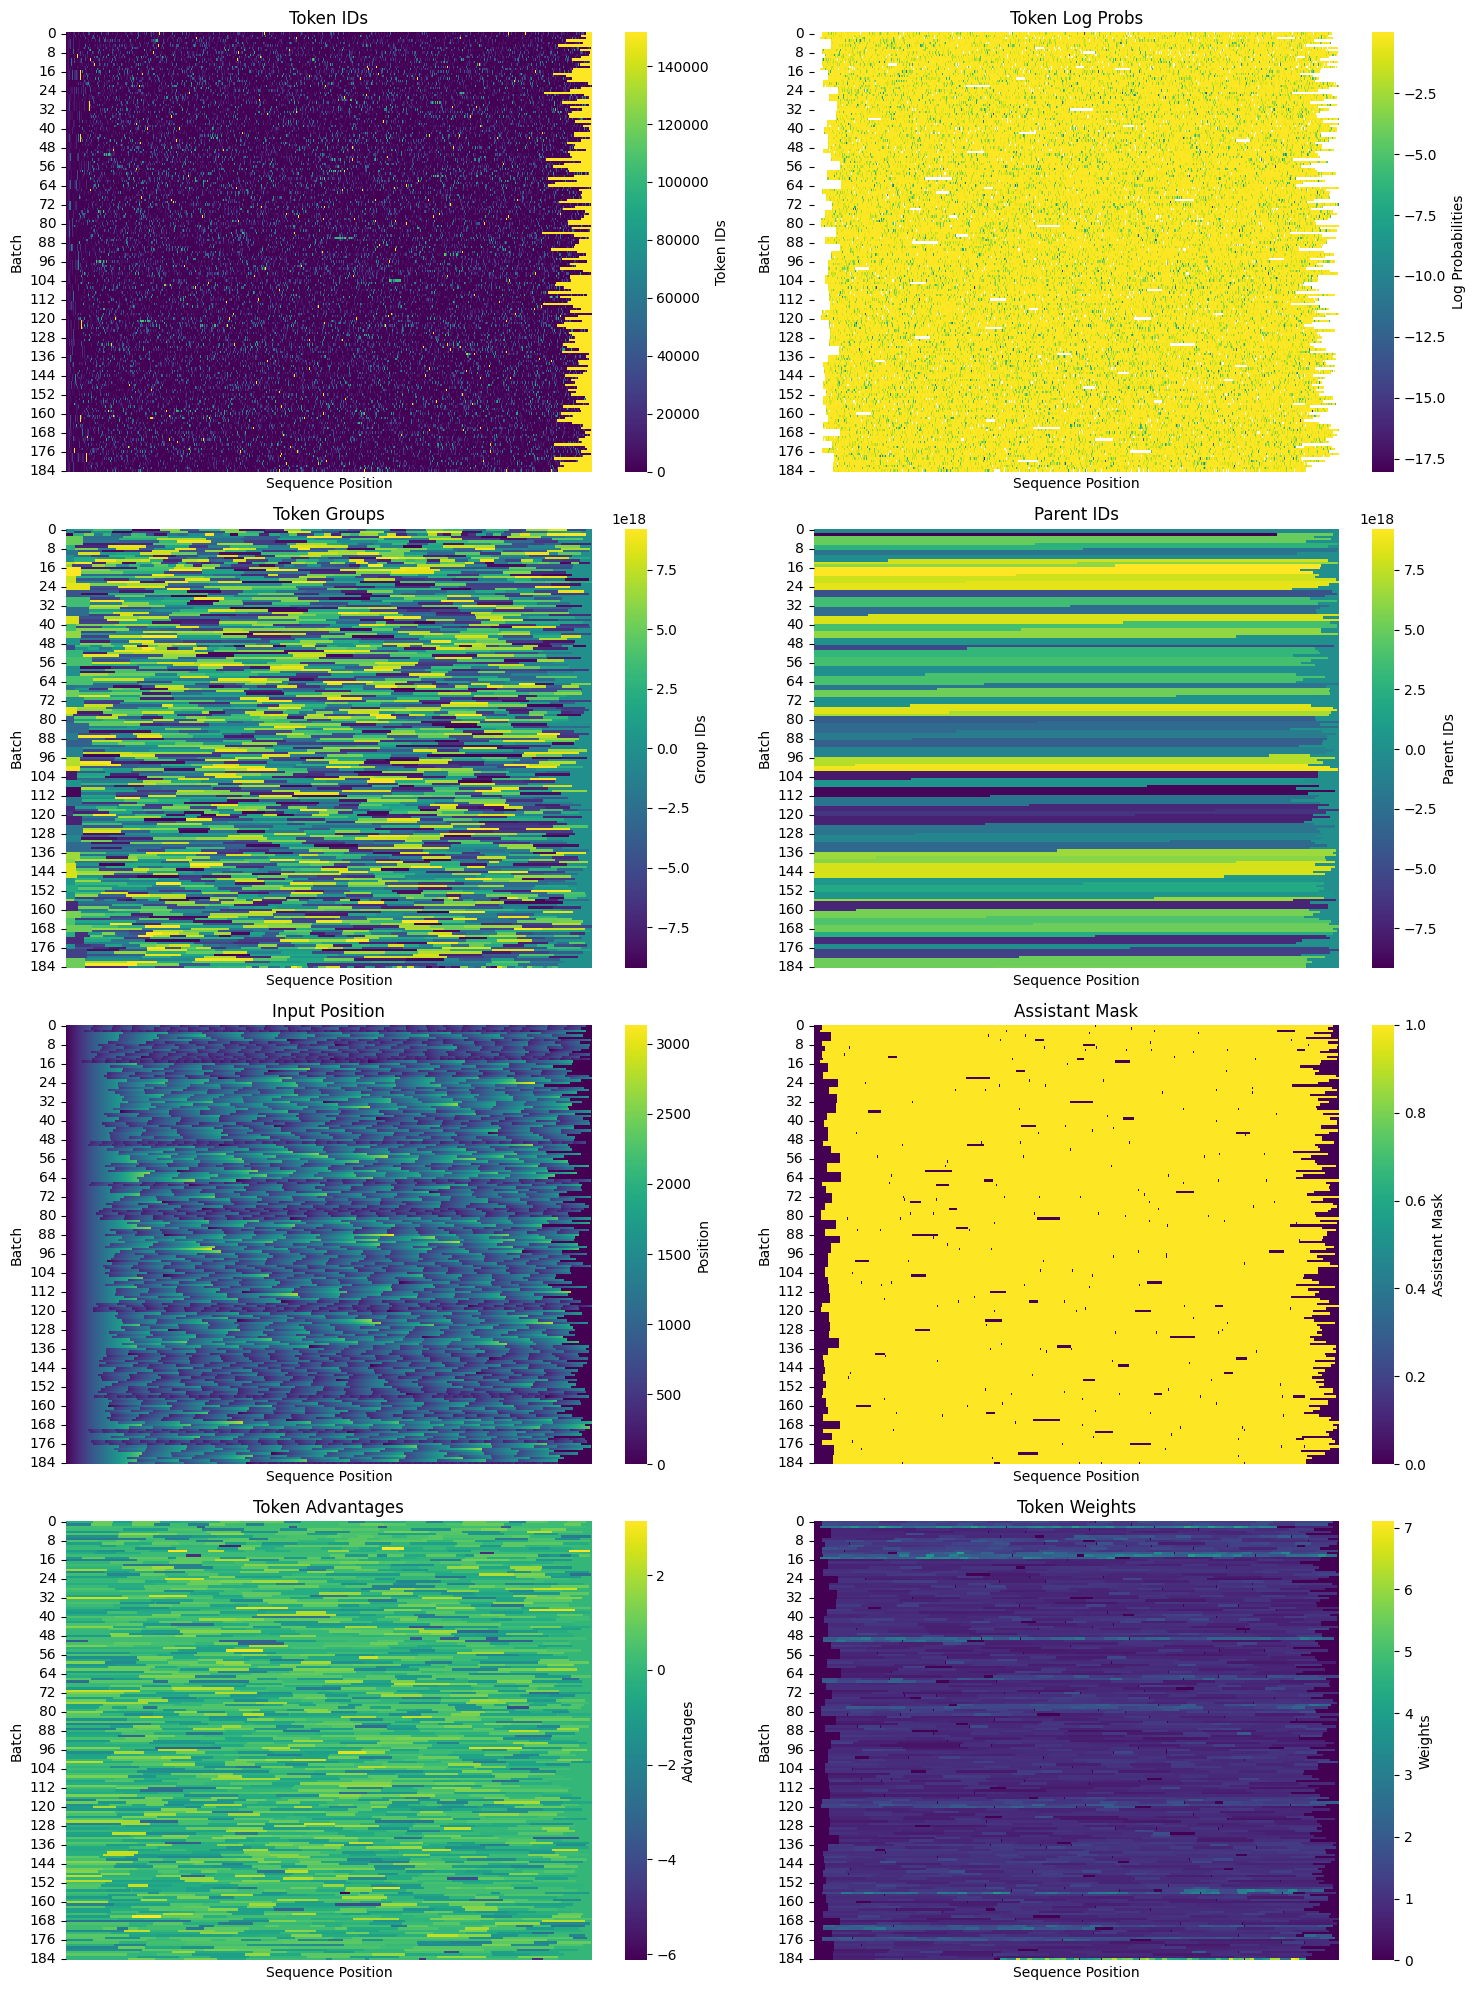

rsyncing /dev/shm/models/043 to gs:/atreides/openpipe/models/043
$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/043/config.yaml
Running with torchrun...


W0224 22:53:21.826000 31827 torch/distributed/run.py:793] 
W0224 22:53:21.826000 31827 torch/distributed/run.py:793] *****************************************
W0224 22:53:21.826000 31827 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0224 22:53:21.826000 31827 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer

Writing logs to models/043/logs/log_1740437607.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 34.71 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.81 GiB
	GPU peak memory reserved: 3.88 GiB
	GPU peak memory active: 3.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|17|Loss: 0.0004:  74%|███████▍  | 17/23 [14:24<04:55, 49.26s/it, entropy=0.542, kl_div=nan, loss=0.000362, policy=0.000362]   

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=240 + 30 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=model.tune_num_output_chunks,
            compile=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))